# Generate Music With Diffusion Models
In this notebook we will implement a Diffusion Probabilistic Model to generate music from raw waveform.
A Diffusion Model learns to invert a Markov process that progressively adds gaussian noise to the signal until the signal is completely destroyed. As shown in the figure.

<center><img src="images/diff_model.png"/></center>

The forward process $q(x_t | x_{t-1})$ is fixed, and it can be parametrized as:

$$
q(x_t|x_{t-1}) = N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_t I)
$$
Where $\beta_1$,...,$\beta_t$ are givern by a fixed variance schedule (in our case the betas are set to be linearly increasing constants from $10^{-4}$ to 0.02 as in [1]).

If the steps are small enough also the backward process is a gaussian process of the form:

$$
p(x_{t-1}|x_t) = N(x_{t-1},\mu_\theta(x_t,t),\Sigma_\theta(x_t,t))
$$
Where $\mu_\theta$ and $\Sigma_\theta$ are parametric functions with parameters $\theta$.

Diffusion Models are latent variable models of the form:
$$ p_\theta(x_0) = \int p_\theta(x_{0:T}) dx_{1:T}$$
where $x_1$,...,$x_T$ are latents with the same dimensionality of the data $x_0 \sim q(x_0)$.
However the distribution $p_\theta(x_0)$ cannot be optimized directly maximizing the log-lokelihood for the intractability of the integral. Hence we optimize the model maximizing the ELBO:
$$
E_{x_{1:T}}[\log{\frac{p_\theta(x_{0:T})}{p(x_{1:T}|x_0)}}]
$$

The maximization of the ELBO can be reduced to the minimization of a loss that compares directly the learned backward process $p_\theta(x_{t-1}|x_t)$ with the posterior $q(x_{t-1}|x_t,x_0) = N(x_{t-1};\tilde{\mu_t}(x_t,x_0),\tilde{\beta}_tI)$, that is tractable when conditioned on $x_0$. 

We adopted the same reparametrization introduced in [1], according to which:
$$
\tilde{\mu_t}(x_t,x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}x_0 + \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t
$$
$$
\tilde{\beta}_t = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t
$$
$$
\bar{\alpha_t} = \prod_{s=1}^t \alpha_s
$$
$$
\alpha_t = 1-\beta_t
$$


In [1]:
import tensorflow as tf
from params import params
from data.dataset import get_wav,get_unlabelled_dataset
import math
import subprocess
import os
from network.model import DiffWaveNet
from diffusion.diffusion_process import *
import matplotlib.pyplot as plt

2022-08-25 12:20:31.814700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset
To train the model we used the <a href="https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification">GTZAN</a> dataset. that contains 1000 traks categorized in 10 genres, even though the categorization is not used in this project. 
### Preprocessing
Each sample is a mono audio file (one channel) that is 30 seconds long with a sampling rate of 22.5 kHz. This implies that each sample is a tensor with shape (675000,1). This sequence length was too long to efficiently train the neural network (that will be described in the next section). For this reason each audio file was downsampled by a factor 3. In order to prevent aliasing, before downsampling, the signal was passed through a low pass filter, that was implemented from scratch in order to be fully integrated in the data pipeline. The low pass filter is implemented by the method `data.dataset.low_pass(signal,fc,npoints=128)` that takes as input a signal with shape (seq_len,n_channels) and the cutoff frequency fc and it returns the same signal without all the frequency components that are above the cutoff. In order to further reduce the number of samples each downsampled audiofile was split into 6 samples.
The data pipeline is implemented by the method `data.dataset.get_unlabelled_dataset(bs=None,nsplits=1,downsample=1)`, while the values of the parameters used for training are stored in the file `params.py`.
In order to train the model efficiently the dataset was cached in the directory `dataset` where the folder `unlabelled` contains the while batched dataset (about 6000 tracks) while `unlabelled_10` the batched dataset with only 10 samples (40 tracks since the batch size is 4).

In [2]:
# if the preprocessed dataset does not exist, then
# create it
if not os.path.exists("dataset/unlabelled_10"):
    ds = get_unlabelled_dataset(params["BS"],nsplits=params["NSPLITS"],downsample=params["DOWNSAMPLE"]).take(10)
    tf.data.experimental.save(
    ds, "./dataset/unlabelled_10")

In [3]:
# set this counter to the number of batches (4 samples each)
# you want to listen
count = 1

ds = tf.data.experimental.load("./dataset/unlabelled_10",tf.TensorSpec(shape=(params["BS"],math.ceil((params["NSAMPLES"]//params["NSPLITS"])/params["DOWNSAMPLE"]),1), dtype=tf.float32))
for curr,x in enumerate(ds):
    if curr >= count:
        break
    for i in range(x.shape[0]):
        wav = get_wav(x[i],params["SR"]//params["DOWNSAMPLE"])
        subprocess.run(["ffplay","-"],input=wav.numpy())


ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

## Model
As we already discussed, the maximization of the ELBO can be reduced to the minimization of a loss that compares directly the learned backward process $p_\theta(x_{t-1}|x_t)$ with the posterior $q(x_{t-1}|x_t,x_0)$. 
In particular if we recall that 
$$
p_\theta(x_{t-1}|x_t) = N(x_{t-1};\mu_\theta(x_t,t),\sigma^2_tI)
$$
(where we simplified the previous formulation assuming that $\Sigma_\theta(x_t,t) = \sigma^2_tI$ with $\sigma_t^2 = \beta_t$) and
$$
q(x_{t-1}|x_t,x_0) = N(x_{t-1};\tilde{\mu_t}(x_t,x_0),\tilde{\beta}_tI)
$$
then the maximization of the ELBO can be reduced to the minimization of:
$$
E_{t\sim Uniform(1,T)\land x_t\sim q}[\frac{1}{2\sigma^2_t}||\tilde{\mu}_t(x_t,x_0)-\mu_\theta(x_t,t)||^2]
$$
Moreover, it can be shown that by reparametrizing 
$$
x_t \sim q(x_t|x_0) = N(x_t;\sqrt{\bar{\alpha_t}}x_0,(1-\bar{\alpha_t})I)
$$
with 
$$
x_t(x_0,\epsilon) = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1-\bar{\alpha_t}}\epsilon, \quad\epsilon\sim N(0,I)
$$
than, the loss can be formulated as:
$$
L = || \epsilon - \epsilon_\theta(\sqrt{\bar{\alpha_t}}x_0 + \sqrt{1-\bar{\alpha_t}}\epsilon,t)||^2
$$


At the end of the day, what we need to implement is a neural network $\epsilon_\theta$ that takes as input a sample at any given step t of the forward process $x_t \sim q(x_t|x_0)$ along with the positional encoding of the step t and predicts the gaussian noise $\epsilon$ (that has the same dimensionality as $x_t$).

The positional encoding is implemented by the function `diffusion.positional_encoder.encode(pos,dmodel,n=10000)` as described in [2] while.
The plot below shows an example of positional encoding with dimension 128 and 20 steps.

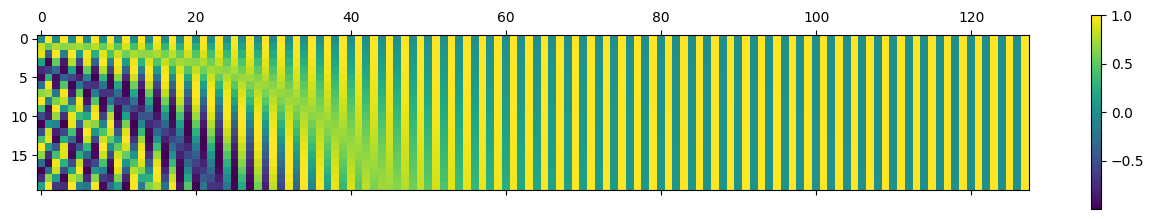

In [4]:
dmodel=128
steps = 20
encodings = []
for k in range(steps):
    # convert to tensor to avoid tf.function retracing
    encodings += [encode(tf.convert_to_tensor(k,tf.float32),tf.convert_to_tensor(dmodel,tf.float32))]
encodings = tf.stack(encodings,axis=0)
cax = plt.matshow(encodings)
plt.gcf().colorbar(cax)
plt.show()

The neural network is an implementation of the DiffWave network presented in [3] for speech sinthesys.
The model architecture is represented in the figure:
<center><img src="./images/arch.png" width=600px></img></center>

The model was trained with the algorithm in the figure, as in [1]:

<center><img src="./images/train_alg.png" width=500px></img></center>

## Generation
After training, the model can be used to generate new samples from gaussian noise. In particular we sample $x_T \sim N(0,I)$ and then we repeat the backward process for the fixed number of steps. This process consists in sampling $x_{t-1} \sim p_\theta(x_{t-1}|x_t)$ starting from $x_T$ and repeating untill $x_0$ is reached. For simplicity, instead of sampling directly $x_{t-1}$ from $p_\theta(x_{t-1}|x_t)$ we can use the same reparametrization we introduced before and compute:
$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon_\theta(x_t,t)) + \sigma_t z
$$
with 
$$
z \sim N(0,1)
$$
The algorithm is illustrated in the following figure:
<center><img src="./images/sampl_alg.png" width=500px></img></center>

The sampling algorithm is implemented by the function `diffusion.diffusion_process.backward_process(model,shape,diffusion_steps,return_sequence=False,step_emb_dim:int=128)` that takes as input the neural network, the shape of the sample, and the number of diffusion steps, if return_sequence is set to true the function returns all the intermediate samples $x_t$ with $t \in [T-1, T-2, ...,0]$. It is important to note that the neural network is composed of convolutional layers, with the exception of the branch that takes as input the positional embedding, which shape does not depend on the sequence length. This implies that the network can generate samples with arbitrary length, independently of the sequence length used for training. For this reason in the `backward_process` function we can specify the shape of the sample.


## Results
In order to test the correctness of the implementation, the model was first trained on a single batch (four samples) for 1 Million steps. The loss is shown in the following figure:

<center><img src="./images/test_loss.png" width=600px></img></center>

The weights were saved under the directory `test/model_test/`.
This is the generated audio track:


In [5]:
# number of samples of the generated track
NSAMPLES = 66000
# instantiate the network
test_net = DiffWaveNet(10,64,3)
# load weights
test_net.load_weights(f"test/model_test/diff_wave_net")
# run the backward process
x_0_gen = backward_process(test_net,(1,NSAMPLES,1),params["DIFF_STEPS"])
# convert output tensor to a wav audio file
wav = get_wav(x_0_gen[0],params["SR"]//params["DOWNSAMPLE"])
# play the audio file with ffmpeg
subprocess.run(["ffplay","-"],input=wav.numpy())

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

CompletedProcess(args=['ffplay', '-'], returncode=0)

After that the model was trained on 40 tracks. The train loop is implemented in `diffusion.diffusion_process.train`. The method saves the weights of the network each 1000 steps. The weights at any available checkpoint can be loaded before generating an audio track. The available checkpoints are stored in the directory `ckpt_10`.
This is an example of generated sample:

In [6]:
# change this parameter to see the results at different
# training steps, the available checkpoints are stored
# in ckpt/
CKPT_STEP = 1000000
net = DiffWaveNet(params["DEPTH"],params["CHANNELS"],params["KERNEL_SIZE"])
params["MODEL_NAME"] = net.name
net.load_weights(os.path.join("ckpt_10",f"__step_{CKPT_STEP}__diff_wave_net"))

In [7]:
# number of samples of the generated track
NSAMPLES = 66000
# run the backward process
x_0_gen = backward_process(net,(1,NSAMPLES,1),params["DIFF_STEPS"])
# convert output tensor to a wav audio file
wav = get_wav(x_0_gen[0],params["SR"]//params["DOWNSAMPLE"])
# play the audio file with ffmpeg
subprocess.run(["ffplay","-"],input=wav.numpy())

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

CompletedProcess(args=['ffplay', '-'], returncode=0)

To analyze the generation process we can also give as input to the network a sample from an arbitrary step t of the forward process instead of pure gaussian noise. In order to do this we first need to sample $x_0$ from the dataset, then we run the forward process for t steps:
$$
x_1 \sim q(x_1|x_0)
$$
$$
x_2 \sim q(x_2|x_1)
$$
$$
...
$$
$$
x_t \sim q(x_t | x_{t-1})
$$
Then we run t steps of the backward process to recover $x_0$:
$$
x_{t-1} \sim p_\theta(x_{t-1}|x_t)
$$
$$
...
$$
$$
x_0 \sim p_\theta(x_0|x_1)
$$

In [8]:
x_0 = next(iter(ds))

In [9]:
beta = variance_schedule(params["DIFF_STEPS"])
alpha = get_alpha(beta)
alpha_hat = get_alpha_hat(alpha)
beta_hat = get_beta_hat(alpha_hat,beta)

Set the value of `t` to the desired forward step (between 1 and 19) and play the cell above to listen to the track corrupted with `t` steps of forward process. 

In [10]:
# the forward step that is given as input to the model
# choose a value between [1,19]
t = 19

x_0_forw,_ = forward(x_0,alpha_hat,t)
print("-> Listening Noisy song")
for i in range(x_0.shape[0]):
    wav = get_wav(x_0_forw[i],params["SR"]//params["DOWNSAMPLE"])
    subprocess.run(["ffplay","-"],input=wav.numpy())

-> Listening Noisy song


ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Input #0, wav, from 'pipe:':aq=    0KB vq=    0KB sq=    0B f=0/0   
  Duration: N/A, bitrate: 117 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 7350 Hz, 1 channels, s16, 117 kb/s


ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Play the cell below to listen the corrupted tracks denoised with `t` steps of backward process.

In [11]:
x_0_back = backward_process_from(net,x_0.shape,params["DIFF_STEPS"],x_0_forw,t)
print("-> Listening Denoised")
for i in range(x_0.shape[0]):
    wav = get_wav(x_0_back[i],params["SR"]//params["DOWNSAMPLE"])
    subprocess.run(["ffplay","-"],input=wav.numpy())

-> Listening Denoised


ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

We repeated the same experiment training the model on the whole dataset but the results were not so satisfactory. Probably the model has not enough capacity to model the complex probability distribution of the data. In fact the model is relatively small, as shown in the summary table below. It would be interesting to repeat the experiment after increasing the capacity of the model, but this was not possible with the available hardware.

In [12]:
net.summary()

Model: "diff_wave_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_33 (Conv1D)          multiple                  128       
                                                                 
 dense_12 (Dense)            multiple                  66048     
                                                                 
 dense_13 (Dense)            multiple                  262656    
                                                                 
 residual_layer_10 (Residual  multiple                 53504     
 Layer)                                                          
                                                                 
 residual_layer_11 (Residual  multiple                 53504     
 Layer)                                                          
                                                                 
 residual_layer_12 (Residual  multiple             

In [13]:
# change this parameter to see the results at different
# training steps, the available checkpoints are stored
# in ckpt/
CKPT_STEP = 1000000
net = DiffWaveNet(params["DEPTH"],params["CHANNELS"],params["KERNEL_SIZE"])
params["MODEL_NAME"] = net.name
net.load_weights(os.path.join("ckpt",f"__step_{CKPT_STEP}__diff_wave_net"))

This is an example of a track generated from pure gaussian noise:

In [14]:
# number of samples of the generated track
NSAMPLES = 66000
# run the backward process
x_0_gen = backward_process(net,(1,NSAMPLES,1),params["DIFF_STEPS"])
# convert output tensor to a wav audio file
wav = get_wav(x_0_gen[0],params["SR"]//params["DOWNSAMPLE"])
# play the audio file with ffmpeg
subprocess.run(["ffplay","-"],input=wav.numpy())

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

CompletedProcess(args=['ffplay', '-'], returncode=0)

These are examples of tracks generated from the chosen step `t` from the forward process:

In [15]:
x_0 = next(iter(ds))

In [16]:
beta = variance_schedule(params["DIFF_STEPS"])
alpha = get_alpha(beta)
alpha_hat = get_alpha_hat(alpha)
beta_hat = get_beta_hat(alpha_hat,beta)

Set the value of `t` to the desired forward step (between 1 and 19) and play the cell above to listen to the track corrupted with `t` steps of forward process. 

In [17]:
# the forward step that is given as input to the model
# choose a value between [1,19]
t = 19

x_0_forw,_ = forward(x_0,alpha_hat,t)
print("-> Listening Noisy song")
for i in range(x_0.shape[0]):
    wav = get_wav(x_0_forw[i],params["SR"]//params["DOWNSAMPLE"])
    subprocess.run(["ffplay","-"],input=wav.numpy())

-> Listening Noisy song


ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Input #0, wav, from 'pipe:':aq=    0KB vq=    0KB sq=    0B f=0/0   
  Duration: N/A, bitrate: 117 kb/s
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 7350 Hz, 1 channels, s16, 117 kb/s


Play the cell below to listen the corrupted tracks denoised with `t` steps of backward process.

In [18]:
x_0_back = backward_process_from(net,x_0.shape,params["DIFF_STEPS"],x_0_forw,t)
print("-> Listening Denoised")
for i in range(x_0.shape[0]):
    wav = get_wav(x_0_back[i],params["SR"]//params["DOWNSAMPLE"])
    subprocess.run(["ffplay","-"],input=wav.numpy())

-> Listening Denoised


ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

ffplay version 4.2.7-0ubuntu0.1 Copyright (c) 2003-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

## Conclusion
In this project we implemented from scratch a diffusion model for raw audio music generation. From the results it emerges that probably the model has not enough capacity and the quality of the generated samples degradates when the size of the trainingset increase. It would be interesting for a future work to increase the model capacity on a more powerful hardware.

## Bibliography
- [1] Ho, Jonathan, Ajay Jain, and Pieter Abbeel. "Denoising diffusion probabilistic models." Advances in Neural Information Processing Systems 33 (2020): 6840-6851.
- [2] Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems 30 (2017).
- [3] Kong, Zhifeng, et al. "Diffwave: A versatile diffusion model for audio synthesis." arXiv preprint arXiv:2009.09761 (2020).